# Model Evaluation

## 1. Setup

In [1]:
# NECESSARY IMPORTS
import pandas as pd
import numpy  as np

from keras.models     import Sequential
from keras.layers     import Dense, Dropout, Activation, Flatten, advanced_activations
from keras.layers     import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam

from keras.utils.data_utils import get_file
from keras import initializations
from keras.callbacks import ModelCheckpoint
import keras.backend     as K
import matplotlib.pyplot as plt

from pandas                     import Series
from scipy.misc                 import imresize
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image  import (ImageDataGenerator, 
                                        array_to_img,
                                        img_to_array,
                                        load_img)
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

Using TensorFlow backend.


In [2]:
# VGG16-Face Pre-trained weights download links
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
VGG16_LOCAL_W   = "'vgg16_weights_tf_dim_ordering_tf_kernels.h5'"

In [3]:
%matplotlib inline

In [4]:
# Ensure reproducibility
np.random.seed(0)

In [5]:
# Path constants
DATA_TEMPLATE     = "./../../data/"
ADIENCE_META_P    = DATA_TEMPLATE + "adience/meta"
ADIENCE_RAW_P     = DATA_TEMPLATE + "adience/keras_format"
ADIENCE_AGE_P     = ADIENCE_RAW_P + "/age"
ADIENCE_GEN_P     = ADIENCE_RAW_P + "/gender"
IMG_PATH          = DATA_TEMPLATE + "wiki/%s"

WIKI_META_P       = DATA_TEMPLATE + "wiki_meta"
MODEL_TEMPLATE    = "./models/%s"
WEIGHTS_TEMPLATE  = "./weights/%s"
GRAPHS_TEMPLATE   = "./graphs/%s"
HISTORY_TEMPLATE   = "./histories/%s"

In [6]:
# Independent constants
MODEL_NAME = "1_gender_DEX_OG-Leaky"
INITIALIZATION = 'normal'
LOSS           = "binary_crossentropy"
OPTIMIZER      = SGD(lr=1e-3, momentum=0.9, decay=5e-4)
BATCH_SIZE     = 32


PIC_NAME     = GRAPHS_TEMPLATE % (MODEL_NAME + ".png")
PIC_NAME_FINETUNING = GRAPHS_TEMPLATE % (MODEL_NAME + "_finetuning_.png")
WEIGHTS_NAME = WEIGHTS_TEMPLATE % (MODEL_NAME + ".h5")
TRA_HISTORY_NAME = HISTORY_TEMPLATE % (MODEL_NAME + "_train_"+".npy")
VAL_HISTORY_NAME = HISTORY_TEMPLATE % (MODEL_NAME + "_valid_"+".npy")


WEIGHTS_NAME_FINETUNING = WEIGHTS_TEMPLATE % (MODEL_NAME + "_finetuning_.h5")
TRA_HISTORY_NAME_FINETUNING = HISTORY_TEMPLATE % (MODEL_NAME + "_train_"+"_finetuning_.npy")
VAL_HISTORY_NAME_FINETUNING = HISTORY_TEMPLATE % (MODEL_NAME + "_valid_"+"_finetuning_.npy")

IMG_WIDTH  = 227
IMG_HEIGHT = 227


ADIENCE_FULL = ["idx","user_id","face_id","original_image","gender","age","img_path","keras_path"]
ADIENCE_HEADER = ["user_id","face_id","original_image","gender","age","img_path","keras_path"]
WIKI_HEADER    = ["full_path","age","gender"]

NUM_EPOCHS  = 1500
NUM_EPOCHS2 = 500


BEST_CHECKPOINT = MODEL_NAME + ".weights.{epoch:02d}-{val_loss:.2f}.hdf5"
BEST_CHECKPOINT_FINE = MODEL_NAME + "FINETUNE.weights.{epoch:02d}-{val_loss:.2f}.hdf5"

In [7]:
callback1 = ModelCheckpoint(BEST_CHECKPOINT, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=10)

In [8]:
callback2 = ModelCheckpoint(BEST_CHECKPOINT_FINE, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=10)

In [9]:
# Dependent constants
IMG_DIMS = (IMG_WIDTH, IMG_HEIGHT)
MODEL_W  = MODEL_NAME + ".h5"
MODEL_P  = MODEL_NAME + ".txt" 

## 2. Loading metadata

### Adience

In [10]:
gender_train_path = ADIENCE_META_P + "/gender_train_0.csv"
gender_valid_path = ADIENCE_META_P + "/gender_valid_0.csv"
gender_train = pd.read_csv(filepath_or_buffer =gender_train_path)
gender_valid = pd.read_csv(filepath_or_buffer =gender_valid_path)

gender_train = gender_train[ADIENCE_HEADER]
gender_valid = gender_valid[ADIENCE_HEADER]

In [11]:
age_train_path = ADIENCE_META_P + "/age_train_0.csv"
age_valid_path = ADIENCE_META_P + "/age_valid_0.csv"
age_train = pd.read_csv(filepath_or_buffer =gender_train_path)
age_valid = pd.read_csv(filepath_or_buffer =gender_valid_path)

age_train = age_train[ADIENCE_HEADER]
age_valid = age_valid[ADIENCE_HEADER]

### Wiki

In [12]:
w_gender_train_path = WIKI_META_P + "/gender/train_1.csv"
w_gender_valid_path = WIKI_META_P + "/gender/valid_1.csv"

w_gender_train = pd.read_csv(filepath_or_buffer =w_gender_train_path)
w_gender_valid = pd.read_csv(filepath_or_buffer =w_gender_valid_path)

w_gender_train = w_gender_train[WIKI_HEADER]
w_gender_valid = w_gender_valid[WIKI_HEADER]

In [13]:
w_age_train_path = WIKI_META_P + "/gender/train_1.csv"
w_age_valid_path = WIKI_META_P + "/gender/valid_1.csv"
w_age_train = pd.read_csv(filepath_or_buffer =w_age_train_path)
w_age_valid = pd.read_csv(filepath_or_buffer =w_age_valid_path)

w_age_train = w_age_train[WIKI_HEADER]
w_age_valid = w_age_valid[WIKI_HEADER]

### SHALLOW-ONLY TASK: Fix age ranges

In [14]:
"""
def fix_age_ranges(age):
    if age < 4:
        return "(0, 2)"
    if age < 8:
        return "(4, 6)"
    if age < 15:
        return "(8, 13)"
    if age < 25:
        return "(15, 20)"
    if age < 38:
        return "(25, 32)"
    if age < 48:
        return "(38, 43)"
    if age < 60:
        return "(48, 53)"
    return "(60-100)"

w_age_train["age"]    = w_age_train["age"].apply(lambda x: fix_age_ranges(x))
w_age_valid["age"]    = w_age_valid["age"].apply(lambda x: fix_age_ranges(x))
w_gender_train["age"] = w_gender_train["age"].apply(lambda x: fix_age_ranges(x))
w_gender_valid["age"] = w_gender_valid["age"].apply(lambda x: fix_age_ranges(x))
"""

'\ndef fix_age_ranges(age):\n    if age < 4:\n        return "(0, 2)"\n    if age < 8:\n        return "(4, 6)"\n    if age < 15:\n        return "(8, 13)"\n    if age < 25:\n        return "(15, 20)"\n    if age < 38:\n        return "(25, 32)"\n    if age < 48:\n        return "(38, 43)"\n    if age < 60:\n        return "(48, 53)"\n    return "(60-100)"\n\nw_age_train["age"]    = w_age_train["age"].apply(lambda x: fix_age_ranges(x))\nw_age_valid["age"]    = w_age_valid["age"].apply(lambda x: fix_age_ranges(x))\nw_gender_train["age"] = w_gender_train["age"].apply(lambda x: fix_age_ranges(x))\nw_gender_valid["age"] = w_gender_valid["age"].apply(lambda x: fix_age_ranges(x))\n'

## 3. Data pipeline

### 3.1 Adience

In [15]:
adience_train_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

In [16]:
adience_valid_aug = ImageDataGenerator(rescale=1./255)

### Train

In [17]:
ADIENCE_GENDER_TRAIN_P = ADIENCE_GEN_P + "/train/1"
adience_gender_train_gen = adience_train_aug.flow_from_directory(
    ADIENCE_GENDER_TRAIN_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 10505 images belonging to 2 classes.


In [18]:
ADIENCE_AGE_TRAIN_P = ADIENCE_AGE_P + "/train/1"
adience_age_train_gen = adience_train_aug.flow_from_directory(
    ADIENCE_AGE_TRAIN_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 10505 images belonging to 8 classes.


### Validation

In [19]:
ADIENCE_GENDER_VALID_P = ADIENCE_GEN_P + "/valid/1"
adience_gender_valid_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_GENDER_VALID_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3502 images belonging to 2 classes.


In [20]:
ADIENCE_AGE_VALID_P = ADIENCE_AGE_P + "/valid/1"
adience_age_valid_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_AGE_VALID_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3502 images belonging to 8 classes.


### Test

In [21]:
ADIENCE_GENDER_TEST_P = ADIENCE_GEN_P + "/test/"
adience_gender_test_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_GENDER_TEST_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3445 images belonging to 2 classes.


In [22]:
ADIENCE_AGE_TEST_P = ADIENCE_AGE_P + "/test/"
adience_age_test_gen = adience_valid_aug.flow_from_directory(
    ADIENCE_AGE_TEST_P,
    target_size=IMG_DIMS,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

Found 3445 images belonging to 8 classes.


### 3.2 Wiki

In [23]:
true_path = lambda x: IMG_PATH % x
w_age_train["full_path"]    = w_age_train["full_path"].apply(lambda x: true_path(x))
w_gender_train["full_path"] = w_gender_train["full_path"].apply(lambda x: true_path(x))
w_age_valid["full_path"]    = w_age_valid["full_path"].apply(lambda x: true_path(x))
w_gender_valid["full_path"] = w_gender_valid["full_path"].apply(lambda x: true_path(x))

In [24]:
def get_image(x):
    try:
        val = img_to_array(imresize(load_img(x),IMG_DIMS))
    except:
        val = "ERR"
    return val

In [25]:
# Data generator
def generate_test(df, batch_size, target_feature):
    start, end = 0, batch_size
    while True:
        while end < len(dfs.shape[0]):
            ages_h = list(pd.get_dummies(data["age"]).columns.values)
            ages   = pd.get_dummies(data["age"])
            data[ages_h] = ages
            
            
            genders_h = list(pd.get_dummies(data["gender"]).columns.values)
            genders   = pd.get_dummies(data["gender"])
            data[genders_h] = genders

            sample = data[start:end]
            start += batch_size
            end   += batch_size

            X         = pd.DataFrame(sample["full_path"].apply(lambda x:get_image(x)))
            good_rows = X["full_path"] != "ERR"
            X         = X[good_rows]
            X.reset_index(inplace=True)
            X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
            X = np.vstack(X)
            X /= 255

            #X = model.predict(X, X.shape[0])

            Y = sample[good_rows]
            if target_feature == "age":
                Y = Y[ages_h].as_matrix()
            else:
                Y = pd.get_dummies(Y[genders_h]).as_matrix()
            yield (X,Y)

In [26]:
# Data generator
def generate_data(df, batch_size, target_feature):
    start, end = 0, batch_size
    while True:
        data   = df.sample(frac=1).reset_index(drop=True)
        ages_h = list(pd.get_dummies(data["age"]).columns.values)
        ages   = pd.get_dummies(data["age"])
        data[ages_h] = ages
        
        genders_h = list(pd.get_dummies(data["gender"]).columns.values)
        genders   = pd.get_dummies(data["gender"])
        data[genders_h] = genders
        
        sample = data[start:end]
        
        X         = pd.DataFrame(sample["full_path"].apply(lambda x:get_image(x)))
        good_rows = X["full_path"] != "ERR"
        X         = X[good_rows]
        X.reset_index(inplace=True)
        X = X["full_path"].apply(lambda x: x.reshape((1,)+ x.shape))
        X = np.vstack(X)
        X /= 255
        #X = model.predict(X, X.shape[0])
        
        Y = sample[good_rows]
        if target_feature == "age":
            Y = Y[ages_h].as_matrix()
        else:
            Y = pd.get_dummies(Y[genders_h]).as_matrix()
        yield (X,Y)

In [27]:
w_age_train_gen = generate_data(w_age_train, BATCH_SIZE, "age")
w_age_valid_gen = generate_data(w_age_valid, BATCH_SIZE, "age")
w_gender_train_gen = generate_data(w_gender_train, BATCH_SIZE, "gender")
w_gender_valid_gen = generate_data(w_gender_valid, BATCH_SIZE, "gender")

In [28]:
from keras.engine.topology import Layer
class LRN2D(Layer):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__()
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = X.shape
        half_n = self.n // 2
        input_sqr = T.sqr(X)
        extra_channels = T.alloc(0., b, ch + 2*half_n, r, c)
        input_sqr = T.set_subtensor(extra_channels[:, half_n:half_n+ch, :, :], input_sqr)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i+ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        return {"name": self.__class__.__name__,
                "alpha": self.alpha,
                "k": self.k,
                "beta": self.beta,
"n": self.n}

## 4. Building the model

In [29]:
# VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(IMG_WIDTH, IMG_HEIGHT,3)))

model.add(Convolution2D(64, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation=advanced_activations.LeakyReLU(alpha=0.009), name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), dim_ordering="tf"))

model.add(Flatten())
model.add(Dense(4096, activation=advanced_activations.LeakyReLU(alpha=0.009), name="fc_1"))
model.add(Dense(4096, activation=advanced_activations.LeakyReLU(alpha=0.009), name="fc_w"))
model.add(Dense(1000, activation='softmax',  name="predictions"))

In [30]:
# Obtain VGG16-Face weights
weights_path = get_file(VGG16_LOCAL_W,TF_WEIGHTS_PATH, cache_subdir='models')

In [31]:
# Loading VGG16-Face weights to VGG16 network
model.load_weights(weights_path)

In [32]:
from keras import backend as K

def my_init(shape, name=None):
    return K.variable(np.reshape(np.arange(0, shape[0], 1), (101,1)), name=name)


In [33]:
model.layers.pop()
model.add(Dense(2,activation=advanced_activations.LeakyReLU(alpha=0.009)))

In [34]:
#layer = model.layers[-1]
#layer.trainable = False

for layer in model.layers[:25]:
    layer.trainable = False

In [35]:
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy', 'recall', 'precision','f1score'])

## 6. Training the model

In [36]:
history = model.fit_generator(w_gender_train_gen, 
                              validation_data=w_gender_valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS)

Epoch 1/1500


/usr/local/lib/python2.7/dist-packages/pandas/core/ops.py:739: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = lib.scalar_compare(x, y, op)


32/32 [==============================] - 6s - loss: 6.2014 - acc: 0.5000 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 1.5719 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 2/1500
32/32 [==============================] - 1s - loss: 1.5836 - acc: 0.5000 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 1.1892 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 3/1500
32/32 [==============================] - 1s - loss: 1.1412 - acc: 0.5000 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 0.9571 - val_acc: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_fmeasure: 0.0000e+00
Epoch 4/1500
32/32 [==============================] - 1s - loss: 0.9704 - acc: 0.5000 - recall: 0.0000e+00 - precision: 0.0000e+00 - fmeasure: 0.0000e+00 - val_loss: 0.8134 - val_acc: 0.5000 - val_rec

## 7. Evaluating the results

In [37]:
history.history.keys()

['acc',
 'loss',
 'val_fmeasure',
 'recall',
 'precision',
 'fmeasure',
 'val_acc',
 'val_recall',
 'val_precision',
 'val_loss']

In [40]:
train_history = history.history['acc']
valid_history = history.history['val_acc']

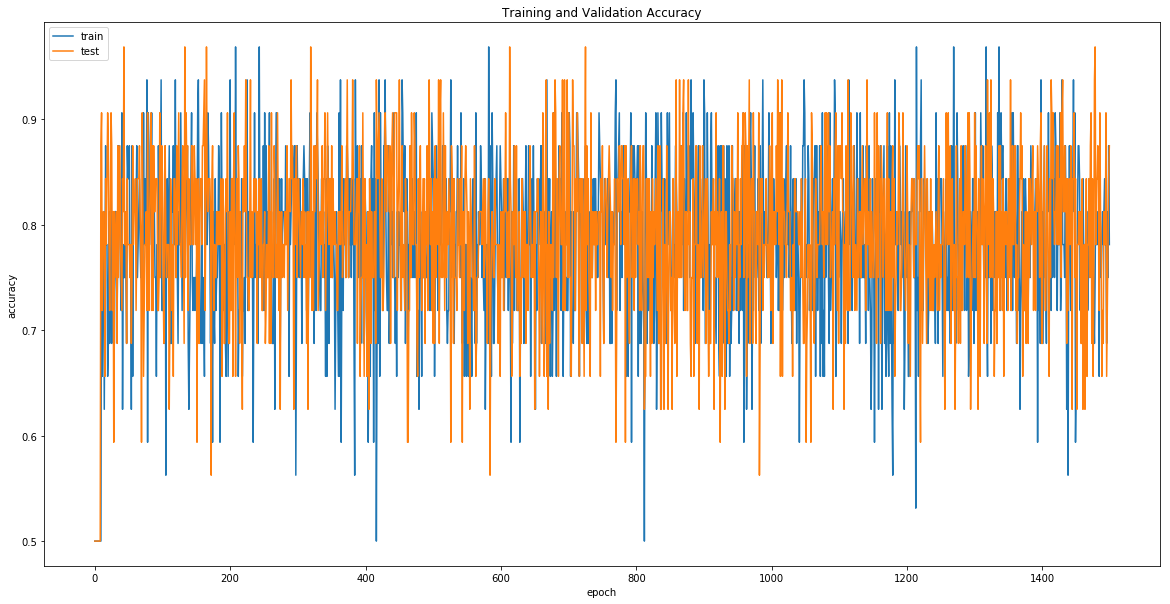

In [41]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(train_history)
plt.plot(valid_history)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(PIC_NAME)

In [42]:
# Tail-rolling average transform
series_train = Series(train_history)
rolling_train = series_train.rolling(window=100)
rolling_mean_train = rolling_train.mean()

series_valid = Series(valid_history)
rolling_valid = series_valid.rolling(window=100)
rolling_mean_valid = rolling_valid.mean()

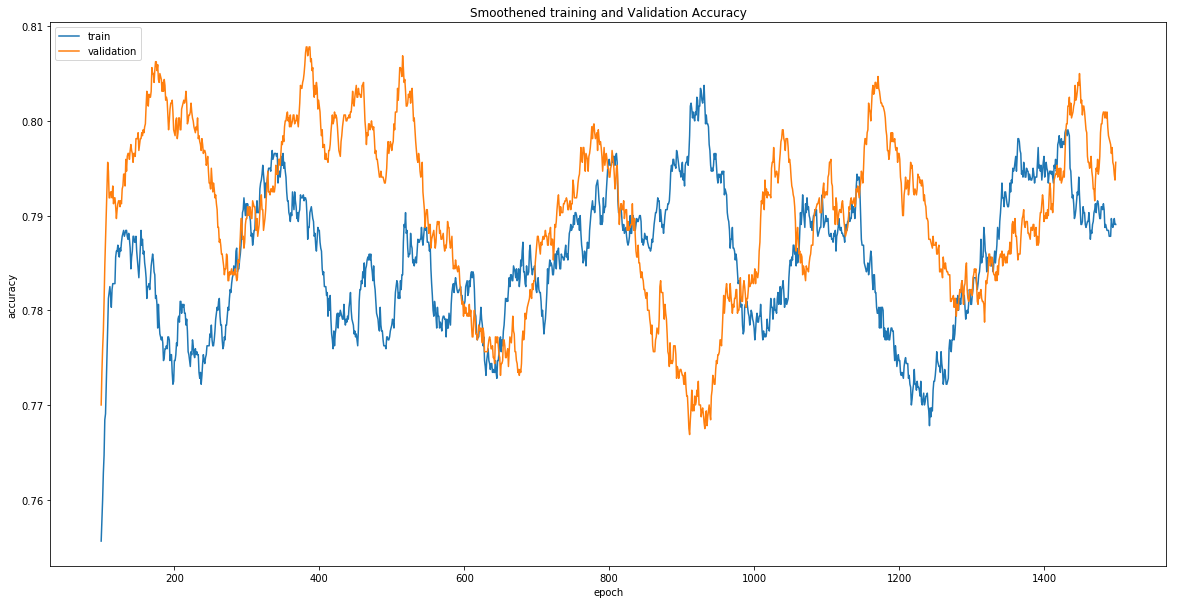

In [43]:
plt.figure(figsize=(20,10))
plt.plot(rolling_mean_train)
plt.plot(rolling_mean_valid)
plt.title('Smoothened training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [44]:
# Saving histories
np.save(TRA_HISTORY_NAME, train_history)
np.save(VAL_HISTORY_NAME, valid_history)

In [45]:
# saving weights
model.save_weights(WEIGHTS_NAME)

### Results on Adience

In [46]:
model.evaluate_generator(adience_gender_test_gen,BATCH_SIZE*400)

[0.93666003937008091,
 0.46223988784148312,
 0.46223988784148312,
 0.46223988784148312,
 0.46223982827400123]

In [47]:
raise EX

NameError: name 'EX' is not defined

## Finetuning with Adience

In [ ]:
history = model.fit_generator(adience_gender_train_gen, 
                              validation_data=adience_gender_valid_gen,
                              nb_val_samples=BATCH_SIZE,
                              samples_per_epoch=BATCH_SIZE, 
                              nb_epoch=NUM_EPOCHS2)

In [ ]:
train_history = history.history['acc']
valid_history = history.history['val_acc']

In [ ]:
 # Plotting training accuracy and testing accuracy acros epochs
plt.figure(figsize=(20,10))
plt.plot(train_history)
plt.plot(valid_history)
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(PIC_NAME_FINETUNING)

In [ ]:
# Tail-rolling average transform
series_train = Series(train_history)
rolling_train = series_train.rolling(window=100)
rolling_mean_train = rolling_train.mean()

series_valid = Series(valid_history)
rolling_valid = series_valid.rolling(window=100)
rolling_mean_valid = rolling_valid.mean()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rolling_mean_train)
plt.plot(rolling_mean_valid)
plt.title('Smoothened training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Saving histories
np.save(TRA_HISTORY_NAME_FINETUNING, train_history)
np.save(VAL_HISTORY_NAME_FINETUNING, valid_history)

In [ ]:
# saving weights
model.save_weights(WEIGHTS_NAME_FINETUNING)

In [ ]:
model.evaluate_generator(adience_gender_test_gen,BATCH_SIZE*400)